In [1]:
#TODO: prettyfy this notebook. All stuff is here

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from consav.linear_interp import interp_1d

In [3]:
# utility
def util(h,w,N,par):
    C = income(h,w,N,par)
    return (C**(1+par.eta))/(1+par.eta) - par.beta*(h**(1+par.gamma))/(1+par.gamma)

# income
def income(h,w,N,par):
    return (1-par.tau)*w*h + N

# solution
def solve(N,par):

    h = np.nan + np.ones(par.w_grid.size)
    for iw,w in enumerate(par.w_grid):
        obj = lambda h: -util(h,w,N,par)
        h_init = np.array([2.0])

        bounds = ((0.0,200.0),)

        res = minimize(obj,h_init,bounds=bounds,method='SLSQP')
        h[iw] = res.x[0]
        
    return h

In [4]:
# parameters 
class par: pass
par.beta = 0.1
par.eta = -2.0
par.gamma = 2.5
par.tau = 0.1

In [6]:
# find optimal labor supply as a function of wages
par.w_grid = np.linspace(1.0,20.0,100)

N = 5.0 # non-labor income. Important for strength of income effect
h = solve(N,par)

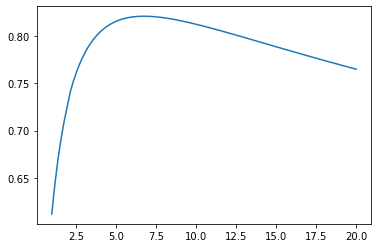

In [7]:
plt.plot(par.w_grid,h);

In [9]:
# Marshall elasticities
S = ((1-par.tau)*par.w_grid*h) / ((1-par.tau)*par.w_grid*h + N)
ela_M = (1+par.eta*S) / (par.gamma - par.eta*S)

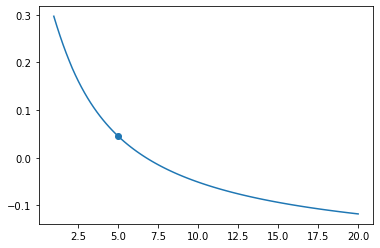

In [10]:
# simulate one point on this curve. One observation is enough because no heterogeneity
w = 5.0
h_sim_base = interp_1d(par.w_grid,h,w)
h_sim_1pct = interp_1d(par.w_grid,h,w*1.01)

ela_M_sim = (h_sim_1pct-h_sim_base)/h_sim_base*100

plt.plot(par.w_grid,ela_M);
plt.scatter(w,ela_M_sim);

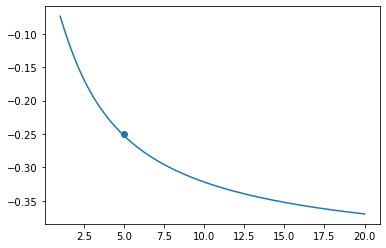

In [11]:
# income effect
# solve model with slightly higher non-labor income
h_N = solve(N*1.01,par)
h_sim_1pct_N = interp_1d(par.w_grid,h_N,w)

ela_I_sim = (h_sim_1pct_N-h_sim_base)/h_sim_base*100
ei_sim = w*h_sim_base*(1-par.tau)* ela_I_sim / N

ei = par.eta*S/(par.gamma - par.eta*S) 

plt.plot(par.w_grid,ei);
plt.scatter(w,ei_sim);

Compensation: -0.0367. Resulting utility difference: -1.4e-08


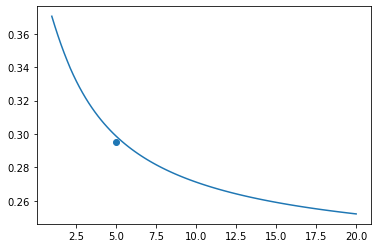

In [12]:
# Hicks: Compensate (or use Slutsky)
# [Compensating with income would lead to a different result. When are they identical? A: when income effect is not that great.]
ela_H = 1/(par.gamma - par.eta*S)

def income_diff(comp,h_base,w,N,par):
    
    inc_base = income(h_base,w,N,par)
    
    # alternative model: increase wage same time as non-labor income
    N_alt = N + comp
    w_alt = w*1.01
    h_alt_vec = solve(N_alt,par)
    h_alt = interp_1d(par.w_grid,h_alt_vec,w_alt)
    inc_alt = income(h_alt,w_alt,N_alt,par)
    
    return inc_base - inc_alt


def util_diff(comp,h_base,w,N,par):
    
    util_base = util(h_base,w,N,par)
    
    # alternative model: increase wage same time as non-labor income
    N_alt = N + comp
    w_alt = w*1.01
    h_alt_vec = solve(N_alt,par)
    h_alt = interp_1d(par.w_grid,h_alt_vec,w_alt)
    util_alt = util(h_alt,w_alt,N_alt,par)
    
    return util_base - util_alt

# find the compensation that equalize utility to baseline level
obj = lambda comp: 1000.0*util_diff(comp,h_sim_base,w,N,par)**2
res = minimize(obj,0.0)
comp = res.x[0]

Dinc = income_diff(comp,h_sim_base,w,N,par)
Dutil = util_diff(comp,h_sim_base,w,N,par)

print(f'Compensation: {comp:2.4f}. Resulting utility difference: {Dutil:2.2g}')

# calculate elasticity with this level of compensation
h_H = solve(N+comp,par)
h_sim_1pct_H = interp_1d(par.w_grid,h_H,w*1.01)
ela_H_sim = (h_sim_1pct_H-h_sim_base)/h_sim_base*100

plt.plot(par.w_grid,ela_H);
plt.scatter(w,ela_H_sim);